In [183]:
# %% Cell 1: Imports
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

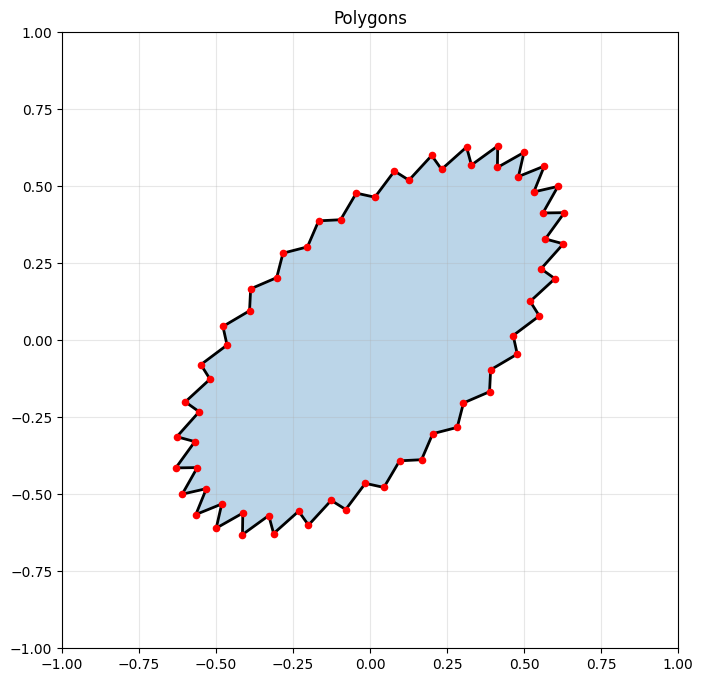

In [184]:
from ainr import generate_polygons, plot_polygons


polygons = generate_polygons('1x32', convex=False, stretch=(1, 0.5), star_ratio=0.9, rotation=np.pi/4)
plot_polygons(polygons)

In [185]:
def robust_pca(vertices: np.ndarray):
    center = vertices.mean(axis=0)
    centered = vertices - center
    
    # Covariance
    cov = centered.T @ centered / len(vertices)
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    
    # Sort descending by variance
    order = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[order]
    axes = eigenvectors[:, order].T.copy()
    
    # Near-equal variance: prefer x-alignment
    if eigenvalues[0] > 1e-10:
        ratio = eigenvalues[1] / eigenvalues[0]
        if ratio > 0.99:
            if abs(axes[1, 0]) > abs(axes[0, 0]):
                axes = axes[::-1].copy()
                eigenvalues = eigenvalues[::-1].copy()
    
    # Deterministic sign: prefer positive x first, then positive y
    for i in range(2):
        if axes[i, 0] < -1e-10:
            axes[i] *= -1
        elif abs(axes[i, 0]) < 1e-10 and axes[i, 1] < -1e-10:
            axes[i] *= -1
    
    return center, axes, eigenvalues

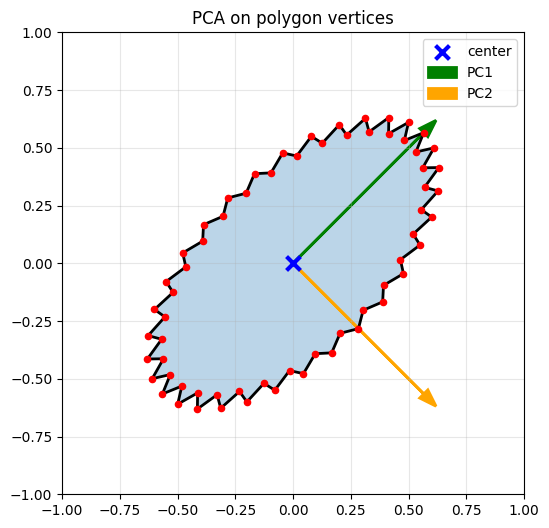

In [186]:
vertices = np.concatenate(polygons, axis=0)
center, axes, variances = robust_pca(vertices)

# Visualize
plt.figure(figsize=(6, 6))

# Draw each polygon with fill and outline (like plot_polygons)
colors = plt.cm.tab10(np.linspace(0, 1, len(polygons)))
for i, polygon in enumerate(polygons):
    # Close polygon by adding first vertex at end
    closed_poly = np.vstack([polygon, polygon[0:1]])
    plt.plot(closed_poly[:, 0], closed_poly[:, 1], 'k-', linewidth=2)
    plt.fill(closed_poly[:, 0], closed_poly[:, 1], color=colors[i], alpha=0.3)

# Mark all vertices
plt.scatter(vertices[:, 0], vertices[:, 1], c='red', s=20, zorder=5)

# Draw center
plt.scatter(*center, c='blue', s=100, marker='x', lw=3, zorder=10, label='center')

# Draw PCA axes
for i, (ax, col) in enumerate(zip(axes, ['green', 'orange'])):
    plt.arrow(center[0], center[1], ax[0]*0.8, ax[1]*0.8, 
              head_width=0.05, color=col, lw=2, label=f'PC{i+1}')

plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True, alpha=0.3)
plt.legend()
plt.title('PCA on polygon vertices')
plt.show()

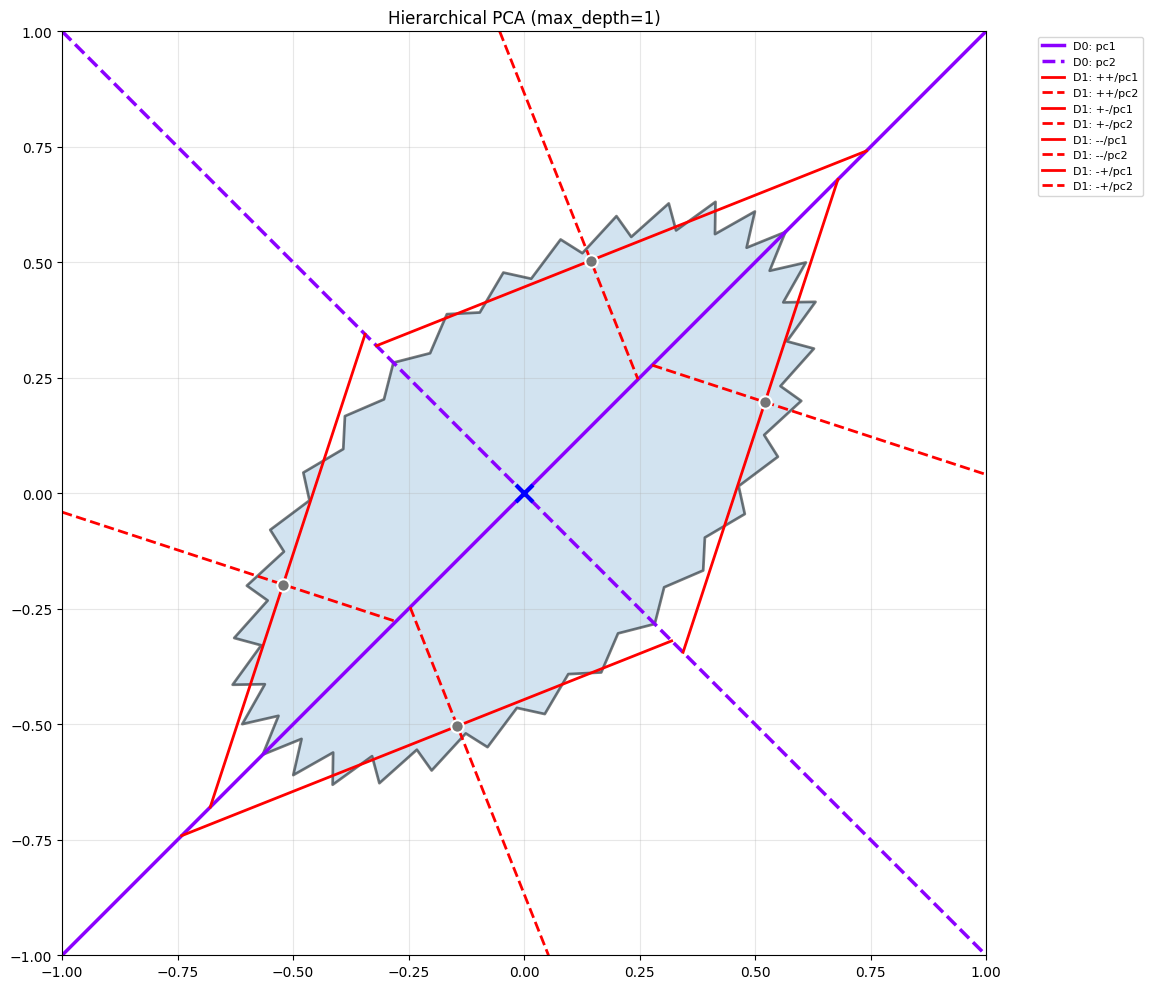

In [187]:
def clip_line(origin, direction, halfspace_normals=None, halfspace_points=None, box_min=-1, box_max=1):
    """Clip line to region, return (t_min, t_max) or (None, None)."""
    direction = direction / np.linalg.norm(direction)
    t_min, t_max = -np.inf, np.inf
    
    # Clip to box
    for i in range(2):
        if abs(direction[i]) > 1e-12:
            t1 = (box_min - origin[i]) / direction[i]
            t2 = (box_max - origin[i]) / direction[i]
            t_min = max(t_min, min(t1, t2))
            t_max = min(t_max, max(t1, t2))
        elif origin[i] < box_min or origin[i] > box_max:
            return None, None
    
    # Clip to half-spaces
    if halfspace_normals is not None:
        for normal, point in zip(halfspace_normals, halfspace_points):
            d_dot_n = np.dot(direction, normal)
            if abs(d_dot_n) > 1e-12:
                t_boundary = np.dot(point - origin, normal) / d_dot_n
                if d_dot_n > 0:
                    t_min = max(t_min, t_boundary)
                else:
                    t_max = min(t_max, t_boundary)
            elif np.dot(point - origin, normal) < 0:
                return None, None
    
    return (t_min, t_max) if t_min <= t_max else (None, None)


def build_hierarchical_pca(vertices, max_depth=2, box_min=-1, box_max=1, 
                           halfspace_normals=None, halfspace_points=None):
    """
    Build hierarchical PCA. Returns dict: {'pc1': (p_start, p_end), 'pc2': (p_start, p_end), '++': {...}, ...}
    
    halfspace_normals/halfspace_points: accumulated constraints from ALL parent levels
    """
    if len(vertices) < 3:
        return None
    
    center, axes, variances = robust_pca(vertices)
    
    # Create line segments for PC1 and PC2
    lines = {}
    for i, pc_key in enumerate(['pc1', 'pc2']):
        t_range = clip_line(center, axes[i], halfspace_normals, halfspace_points, box_min, box_max)
        if t_range[0] is not None:
            direction = axes[i] / np.linalg.norm(axes[i])
            p_start = center + t_range[0] * direction
            p_end = center + t_range[1] * direction
            lines[pc_key] = (p_start, p_end)
    
    node = {'center': center, 'axes': axes, 'variances': variances, **lines}
    
    # Recurse into quadrants
    if max_depth > 0:
        proj = (vertices - center) @ axes.T
        for s1, s2, key in [(1, 1, '++'), (1, -1, '+-'), (-1, -1, '--'), (-1, 1, '-+')]:
            mask = ((np.sign(proj[:, 0]) == s1) | (proj[:, 0] == 0)) & \
                   ((np.sign(proj[:, 1]) == s2) | (proj[:, 1] == 0))
            
            # Accumulate half-spaces: add current level's constraints to existing ones
            new_normals = list(halfspace_normals) if halfspace_normals else []
            new_points = list(halfspace_points) if halfspace_points else []
            new_normals.extend([s1 * axes[0], s2 * axes[1]])
            new_points.extend([center, center])
            
            child = build_hierarchical_pca(vertices[mask], max_depth - 1, box_min, box_max,
                                          new_normals, new_points)
            if child is not None:
                node[key] = child
    
    return node


def plot_hierarchical_pca(node, polygons, depth=0, max_depth=2, path='', quadrant_idx=0):
    """Plot hierarchical PCA structure."""
    if depth == 0:
        plt.figure(figsize=(12, 10))
        
        # Draw polygons
        poly_colors = plt.cm.tab10(np.linspace(0, 1, len(polygons)))
        for i, polygon in enumerate(polygons):
            closed_poly = np.vstack([polygon, polygon[0:1]])
            plt.plot(closed_poly[:, 0], closed_poly[:, 1], 'k-', linewidth=2, alpha=0.5)
            plt.fill(closed_poly[:, 0], closed_poly[:, 1], color=poly_colors[i], alpha=0.2)
    
    if node is None:
        return
    
    # One color per depth level
    depth_colors = ['#8B00FF', '#FF0000', '#00C853', '#00B8D4']  # Purple, Red, Green, Cyan
    
    color = depth_colors[min(depth, len(depth_colors)-1)]
    alpha = 1.0  # No transparency
    
    # Draw center
    marker_size = 150 if depth == 0 else 80
    center_color = ['#0000FF', '#757575', '#BDBDBD'][min(depth, 2)]  # Blue → gray → light gray
    plt.scatter(*node['center'], s=marker_size, 
                marker='x' if depth == 0 else 'o', c=center_color,
                linewidth=3 if depth == 0 else 1.5, zorder=10-depth, alpha=alpha,
                edgecolors=None if depth == 0 else 'white')
    
    # Draw lines - pc1 solid, pc2 dashed
    for pc_idx, pc_key in enumerate(['pc1', 'pc2']):
        if pc_key not in node:
            continue
        
        p_start, p_end = node[pc_key]
        label = f"D{depth}: {path}{pc_key}" if path else f"D{depth}: {pc_key}"
        
        # pc1 = solid line, pc2 = dashed line
        linestyle = '-' if pc_key == 'pc1' else '--'
        
        plt.plot([p_start[0], p_end[0]], [p_start[1], p_end[1]], 
                 color=color, lw=2.5 if depth == 0 else 2, ls=linestyle, 
                 alpha=alpha, label=label)
    
    # Recurse to quadrant children
    for q_idx, quad_key in enumerate(['++', '+-', '--', '-+']):
        if quad_key in node:
            new_path = f"{path}{quad_key}/" if path else f"{quad_key}/"
            plot_hierarchical_pca(node[quad_key], polygons, depth + 1, max_depth, new_path, q_idx)
    
    if depth == 0:
        plt.xlim(-1, 1)
        plt.ylim(-1, 1)
        plt.gca().set_aspect('equal')
        plt.grid(alpha=0.3)
        
        # Place legend to the right of the plot
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, ncol=1)
        plt.title(f'Hierarchical PCA (max_depth={max_depth})')
        plt.tight_layout()
        plt.show()

# Example: Build hierarchical structure with max_depth=1
hierarchy = build_hierarchical_pca(vertices, max_depth=1)

# Visualize
plot_hierarchical_pca(hierarchy, polygons, max_depth=1)

Computing SDF for 10 lines...


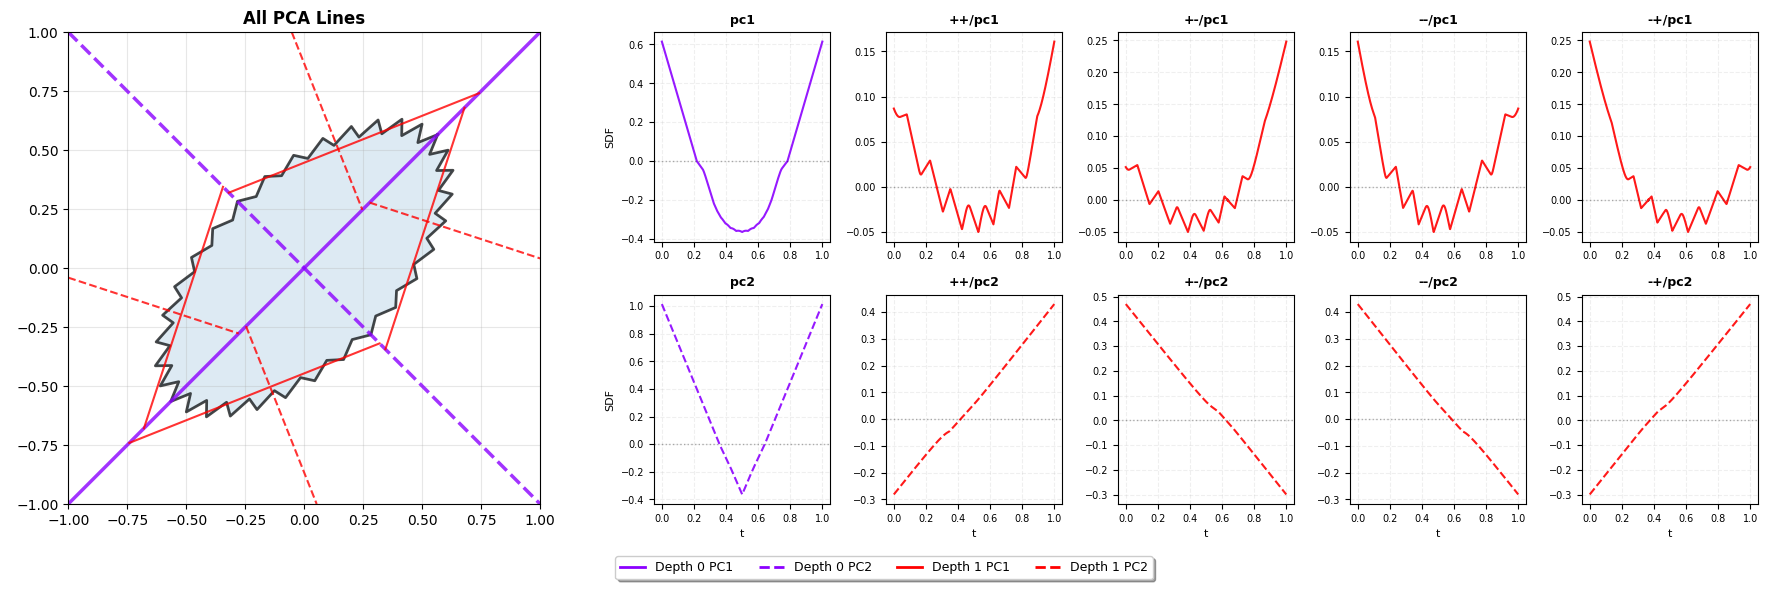

In [192]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

def compute_sdf_sampling(p_start, p_end, polygons, n_samples=1000):
    """Compute SDF along line segment."""
    # Sample line
    t = np.linspace(0, 1, n_samples)
    points = p_start + t[:, None] * (p_end - p_start)
    
    # Sample polygon edges (50 points per edge)
    poly_samples = []
    for poly in polygons:
        for i in range(len(poly)):
            v1, v2 = poly[i], poly[(i + 1) % len(poly)]
            poly_samples.append(v1 + np.linspace(0, 1, 50, endpoint=False)[:, None] * (v2 - v1))
    poly_samples = np.vstack(poly_samples)
    
    # Find nearest distances using KD-tree
    distances = KDTree(poly_samples).query(points)[0]
    
    # Vectorized inside/outside check (ray casting)
    inside = np.zeros(len(points), dtype=bool)
    for poly in polygons:
        v = np.asarray(poly)
        v_next = np.roll(v, -1, axis=0)
        
        # Check ray crossings for all points at once
        py = points[:, 1:2]  # Shape (N, 1)
        v_y, v_next_y = v[:, 1], v_next[:, 1]
        
        # Edges that potentially cross the ray
        crosses = ((v_y <= py) & (py < v_next_y)) | ((v_next_y <= py) & (py < v_y))
        
        # Compute x-intersections
        t_cross = (py - v_y) / (v_next_y - v_y + 1e-10)
        x_cross = v[:, 0] + t_cross * (v_next[:, 0] - v[:, 0])
        
        # Count crossings to the right of each point
        inside |= (np.sum(crosses & (x_cross > points[:, 0:1]), axis=1) % 2 == 1)
    
    return t, np.where(inside, -distances, distances)


def plot_sdf_fancy(line_segments, labels, polygons, n_samples=1000):
    """
    Plot SDF curves: 2D visualization on left, individual SDF plots on right.
    Each line gets its own plot.
    """
    # Compute SDF for all lines
    all_data = []
    for (p_start, p_end), label in zip(line_segments, labels):
        t, sdf = compute_sdf_sampling(p_start, p_end, polygons, n_samples)
        depth = int(label.split(':')[0].replace('D', '')) if 'D' in label else 0
        pc_type = 'pc1' if 'pc1' in label else 'pc2'
        all_data.append({'t': t, 'sdf': sdf, 'label': label, 'line': (p_start, p_end),
                        'depth': depth, 'pc_type': pc_type})
    
    # Separate PC1 and PC2
    pc1_data = [d for d in all_data if d['pc_type'] == 'pc1']
    pc2_data = [d for d in all_data if d['pc_type'] == 'pc2']
    
    depth_colors = ['#8B00FF', '#FF0000', '#00C853', '#00B8D4']
    
    # Calculate number of columns: 1 (2D plot) + number of individual plots
    n_plots = max(len(pc1_data), len(pc2_data))
    
    # Create figure with gridspec
    fig = plt.figure(figsize=(18, 6))
    import matplotlib.gridspec as gridspec
    
    # Width ratios: 2 for 2D plot, then 0.6 for each individual plot
    width_ratios = [2] + [0.6] * n_plots
    gs = gridspec.GridSpec(3, n_plots + 1, figure=fig, 
                          height_ratios=[10, 10, 1], 
                          width_ratios=width_ratios)
    
    # Left: 2D visualization (spans both rows)
    ax_2d = fig.add_subplot(gs[0:2, 0])
    
    # Draw polygons
    poly_colors = plt.cm.tab10(np.linspace(0, 1, len(polygons)))
    for j, poly in enumerate(polygons):
        poly_closed = np.vstack([poly, poly[0]])
        ax_2d.plot(poly_closed[:, 0], poly_closed[:, 1], 'k-', linewidth=2, alpha=0.7)
        ax_2d.fill(poly_closed[:, 0], poly_closed[:, 1], color=poly_colors[j], alpha=0.15)
    
    # Draw all lines
    for data in all_data:
        p_start, p_end = data['line']
        color = depth_colors[min(data['depth'], len(depth_colors)-1)]
        ls = '-' if data['pc_type'] == 'pc1' else '--'
        lw = 2.5 if data['depth'] == 0 else 1.5
        
        ax_2d.plot([p_start[0], p_end[0]], [p_start[1], p_end[1]], 
                   color=color, ls=ls, lw=lw, alpha=0.8)
    
    ax_2d.set_xlim(-1, 1)
    ax_2d.set_ylim(-1, 1)
    ax_2d.set_aspect('equal')
    ax_2d.grid(alpha=0.3)
    ax_2d.set_title('All PCA Lines', fontsize=12, fontweight='bold')
    
    # Right: Individual SDF plots
    # Top row: PC1
    for idx, data in enumerate(pc1_data):
        ax = fig.add_subplot(gs[0, idx + 1])
        color = depth_colors[min(data['depth'], len(depth_colors)-1)]
        
        ax.plot(data['t'], data['sdf'], color=color, ls='-', lw=1.5, alpha=0.9)
        ax.axhline(0, color='black', linestyle=':', alpha=0.3, linewidth=1)
        ax.grid(alpha=0.2, linestyle='--')
        
        # Extract short label (just the path part)
        short_label = data['label'].split(': ')[1] if ': ' in data['label'] else data['label']
        ax.set_title(short_label, fontsize=9, fontweight='bold')
        
        if idx == 0:
            ax.set_ylabel('SDF', fontsize=8)
        ax.tick_params(labelsize=7)
    
    # Bottom row: PC2
    for idx, data in enumerate(pc2_data):
        ax = fig.add_subplot(gs[1, idx + 1])
        color = depth_colors[min(data['depth'], len(depth_colors)-1)]
        
        ax.plot(data['t'], data['sdf'], color=color, ls='--', lw=1.5, alpha=0.9)
        ax.axhline(0, color='black', linestyle=':', alpha=0.3, linewidth=1)
        ax.grid(alpha=0.2, linestyle='--')
        
        short_label = data['label'].split(': ')[1] if ': ' in data['label'] else data['label']
        ax.set_title(short_label, fontsize=9, fontweight='bold')
        ax.set_xlabel('t', fontsize=8)
        
        if idx == 0:
            ax.set_ylabel('SDF', fontsize=8)
        ax.tick_params(labelsize=7)
    
    # Bottom: Legend (spans all columns)
    ax_legend = fig.add_subplot(gs[2, :])
    ax_legend.axis('off')
    
    # Create legend handles
    from matplotlib.lines import Line2D
    legend_handles = []
    
    # Get unique depths present in data
    depths = sorted(set(d['depth'] for d in all_data))
    for depth in depths:
        color = depth_colors[min(depth, len(depth_colors)-1)]
        legend_handles.append(Line2D([0], [0], color=color, lw=2, ls='-', 
                                     label=f'Depth {depth} PC1'))
        legend_handles.append(Line2D([0], [0], color=color, lw=2, ls='--', 
                                     label=f'Depth {depth} PC2'))
    
    ax_legend.legend(handles=legend_handles, loc='center', ncol=6, fontsize=9, 
                    frameon=True, fancybox=True, shadow=True)
    
    plt.tight_layout()
    plt.show()


# Extract all lines from hierarchy
def extract_all_lines(node, depth=0, path='', result=None):
    """Recursively extract all (p_start, p_end) tuples with labels."""
    if result is None:
        result = []
    if node is None:
        return result
    
    for pc in ['pc1', 'pc2']:
        if pc in node:
            label = f"D{depth}: {path}{pc}" if path else f"D{depth}: {pc}"
            result.append((node[pc], label))
    
    for quad in ['++', '+-', '--', '-+']:
        if quad in node:
            extract_all_lines(node[quad], depth + 1, f"{path}{quad}/", result)
    
    return result

# Get all lines
all_lines_data = extract_all_lines(hierarchy)
line_segments = [line for line, _ in all_lines_data]
labels = [label for _, label in all_lines_data]

print(f"Computing SDF for {len(line_segments)} lines...")

# Plot everything
plot_sdf_fancy(line_segments, labels, polygons, n_samples=1000)

In [193]:
import numpy as np

def simplify_sdf_to_knots(t_values, sdf_values, tolerance=0.005):
    """Simplify SDF to knots using Douglas-Peucker + zero crossings."""
    
    def perpendicular_distance(point_idx, start_idx, end_idx):
        x0, y0 = t_values[point_idx], sdf_values[point_idx]
        x1, y1 = t_values[start_idx], sdf_values[start_idx]
        x2, y2 = t_values[end_idx], sdf_values[end_idx]
        dx, dy = x2 - x1, y2 - y1
        if dx == 0 and dy == 0:
            return np.sqrt((x0 - x1)**2 + (y0 - y1)**2)
        return abs(dy * x0 - dx * y0 + x2 * y1 - y2 * x1) / np.sqrt(dx**2 + dy**2)
    
    def douglas_peucker(start_idx, end_idx):
        max_dist, max_idx = 0, start_idx
        for i in range(start_idx + 1, end_idx):
            dist = perpendicular_distance(i, start_idx, end_idx)
            if dist > max_dist:
                max_dist, max_idx = dist, i
        
        if max_dist > tolerance:
            left = douglas_peucker(start_idx, max_idx)
            right = douglas_peucker(max_idx, end_idx)
            return left + right[1:]
        return [start_idx, end_idx]
    
    # Douglas-Peucker
    keep = sorted(set(douglas_peucker(0, len(t_values) - 1)))
    
    # Add zero crossings
    for i in range(len(sdf_values) - 1):
        if sdf_values[i] * sdf_values[i + 1] < 0:
            keep.extend([i, i + 1])
    keep = sorted(set(keep))
    
    knot_t, knot_sdf = t_values[keep], sdf_values[keep]
    
    # Compute error
    sdf_interp = np.interp(t_values, knot_t, knot_sdf)
    max_error = np.max(np.abs(sdf_values - sdf_interp))
    mean_error = np.mean(np.abs(sdf_values - sdf_interp))
    
    return knot_t, knot_sdf, max_error, mean_error


# Compute knots for all lines from previous cell
print(f"Computing knots for {len(line_segments)} lines...")
all_knots = []

for (p_start, p_end), label in zip(line_segments, labels):
    t, sdf = compute_sdf_sampling(p_start, p_end, polygons, n_samples=1000)
    knot_t, knot_sdf, max_err, mean_err = simplify_sdf_to_knots(t, sdf, tolerance=0.005)
    
    depth = int(label.split(':')[0].replace('D', '')) if 'D' in label else 0
    pc_type = 'pc1' if 'pc1' in label else 'pc2'
    
    all_knots.append({
        't': t, 'sdf': sdf,
        'knot_t': knot_t, 'knot_sdf': knot_sdf,
        'max_error': max_err, 'mean_error': mean_err,
        'label': label, 'line': (p_start, p_end),
        'depth': depth, 'pc_type': pc_type
    })
    
    print(f"  {label}: {len(knot_t)} knots, max_err={max_err:.6f}")

print("\nDone!")

Computing knots for 10 lines...
  D0: pc1: 17 knots, max_err=0.005319
  D0: pc2: 7 knots, max_err=0.009216
  D1: ++/pc1: 23 knots, max_err=0.004218
  D1: ++/pc2: 7 knots, max_err=0.004600
  D1: +-/pc1: 30 knots, max_err=0.004006
  D1: +-/pc2: 6 knots, max_err=0.006389
  D1: --/pc1: 23 knots, max_err=0.004218
  D1: --/pc2: 7 knots, max_err=0.004600
  D1: -+/pc1: 30 knots, max_err=0.004006
  D1: -+/pc2: 6 knots, max_err=0.006389

Done!


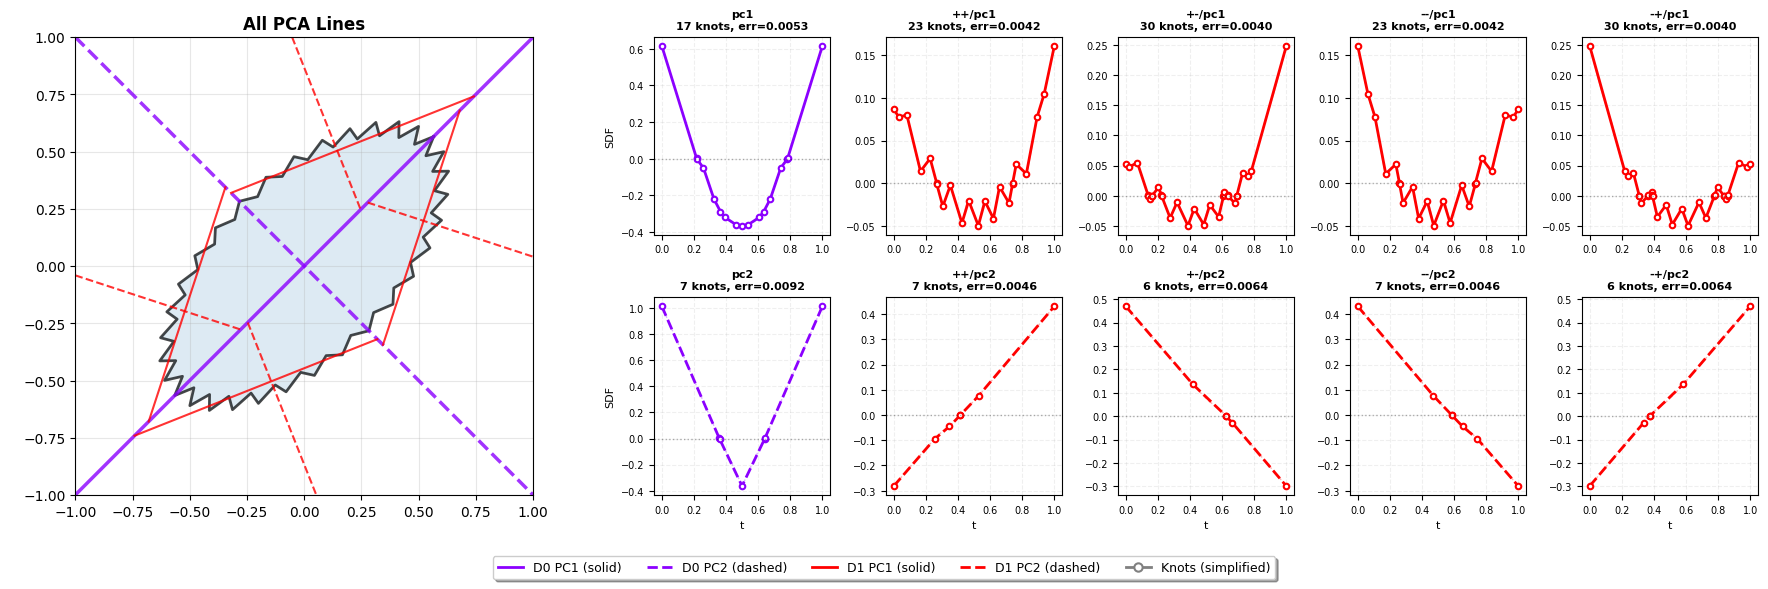


Knot Summary:
Label                Knots    Max Error    Mean Error   Compression
---------------------------------------------------------------------------
pc1                  17       0.005319     0.000945     1.7%
pc2                  7        0.009216     0.001358     0.7%
++/pc1               23       0.004218     0.000903     2.3%
++/pc2               7        0.004600     0.001146     0.7%
+-/pc1               30       0.004006     0.000950     3.0%
+-/pc2               6        0.006389     0.001354     0.6%
--/pc1               23       0.004218     0.000903     2.3%
--/pc2               7        0.004600     0.001146     0.7%
-+/pc1               30       0.004006     0.000950     3.0%
-+/pc2               6        0.006389     0.001354     0.6%


In [194]:
# Plot with knots overlay
def plot_sdf_with_knots(all_knots_data, polygons):
    """Plot SDF curves with knot overlays and error information."""
    
    # Separate PC1 and PC2
    pc1_data = [d for d in all_knots_data if d['pc_type'] == 'pc1']
    pc2_data = [d for d in all_knots_data if d['pc_type'] == 'pc2']
    
    depth_colors = ['#8B00FF', '#FF0000', '#00C853', '#00B8D4']
    n_plots = max(len(pc1_data), len(pc2_data))
    
    # Create figure
    fig = plt.figure(figsize=(18, 6))
    import matplotlib.gridspec as gridspec
    width_ratios = [2] + [0.6] * n_plots
    gs = gridspec.GridSpec(3, n_plots + 1, figure=fig, 
                          height_ratios=[10, 10, 1], 
                          width_ratios=width_ratios)
    
    # Left: 2D visualization
    ax_2d = fig.add_subplot(gs[0:2, 0])
    poly_colors = plt.cm.tab10(np.linspace(0, 1, len(polygons)))
    for j, poly in enumerate(polygons):
        poly_closed = np.vstack([poly, poly[0]])
        ax_2d.plot(poly_closed[:, 0], poly_closed[:, 1], 'k-', linewidth=2, alpha=0.7)
        ax_2d.fill(poly_closed[:, 0], poly_closed[:, 1], color=poly_colors[j], alpha=0.15)
    
    for data in all_knots_data:
        p_start, p_end = data['line']
        color = depth_colors[min(data['depth'], len(depth_colors)-1)]
        ls = '-' if data['pc_type'] == 'pc1' else '--'
        lw = 2.5 if data['depth'] == 0 else 1.5
        ax_2d.plot([p_start[0], p_end[0]], [p_start[1], p_end[1]], 
                   color=color, ls=ls, lw=lw, alpha=0.8)
    
    ax_2d.set_xlim(-1, 1)
    ax_2d.set_ylim(-1, 1)
    ax_2d.set_aspect('equal')
    ax_2d.grid(alpha=0.3)
    ax_2d.set_title('All PCA Lines', fontsize=12, fontweight='bold')
    
    # Right: Individual plots with knots
    # Top row: PC1
    for idx, data in enumerate(pc1_data):
        ax = fig.add_subplot(gs[0, idx + 1])
        color = depth_colors[min(data['depth'], len(depth_colors)-1)]
        
        # Plot dense SDF (thin, transparent)
        ax.plot(data['t'], data['sdf'], color=color, ls='-', lw=1, alpha=0.3)
        
        # Plot knots (thick, opaque)
        ax.plot(data['knot_t'], data['knot_sdf'], 'o-', color=color, 
                lw=2, markersize=4, alpha=1.0, markerfacecolor='white', 
                markeredgewidth=1.5, markeredgecolor=color)
        
        ax.axhline(0, color='black', linestyle=':', alpha=0.3, linewidth=1)
        ax.grid(alpha=0.2, linestyle='--')
        
        short_label = data['label'].split(': ')[1] if ': ' in data['label'] else data['label']
        ax.set_title(f"{short_label}\n{len(data['knot_t'])} knots, err={data['max_error']:.4f}", 
                    fontsize=8, fontweight='bold')
        
        if idx == 0:
            ax.set_ylabel('SDF', fontsize=8)
        ax.tick_params(labelsize=7)
    
    # Bottom row: PC2
    for idx, data in enumerate(pc2_data):
        ax = fig.add_subplot(gs[1, idx + 1])
        color = depth_colors[min(data['depth'], len(depth_colors)-1)]
        
        # Plot dense SDF (thin, transparent)
        ax.plot(data['t'], data['sdf'], color=color, ls='--', lw=1, alpha=0.3)
        
        # Plot knots (thick, opaque)
        ax.plot(data['knot_t'], data['knot_sdf'], 'o--', color=color, 
                lw=2, markersize=4, alpha=1.0, markerfacecolor='white', 
                markeredgewidth=1.5, markeredgecolor=color)
        
        ax.axhline(0, color='black', linestyle=':', alpha=0.3, linewidth=1)
        ax.grid(alpha=0.2, linestyle='--')
        
        short_label = data['label'].split(': ')[1] if ': ' in data['label'] else data['label']
        ax.set_title(f"{short_label}\n{len(data['knot_t'])} knots, err={data['max_error']:.4f}", 
                    fontsize=8, fontweight='bold')
        ax.set_xlabel('t', fontsize=8)
        
        if idx == 0:
            ax.set_ylabel('SDF', fontsize=8)
        ax.tick_params(labelsize=7)
    
    # Bottom: Legend
    ax_legend = fig.add_subplot(gs[2, :])
    ax_legend.axis('off')
    
    from matplotlib.lines import Line2D
    legend_handles = []
    depths = sorted(set(d['depth'] for d in all_knots_data))
    for depth in depths:
        color = depth_colors[min(depth, len(depth_colors)-1)]
        legend_handles.append(Line2D([0], [0], color=color, lw=2, ls='-', 
                                     label=f'D{depth} PC1 (solid)'))
        legend_handles.append(Line2D([0], [0], color=color, lw=2, ls='--', 
                                     label=f'D{depth} PC2 (dashed)'))
    
    # Add knot explanation
    legend_handles.append(Line2D([0], [0], color='gray', lw=2, marker='o', 
                                 markerfacecolor='white', markeredgewidth=1.5,
                                 label='Knots (simplified)'))
    
    ax_legend.legend(handles=legend_handles, loc='center', ncol=7, fontsize=9, 
                    frameon=True, fancybox=True, shadow=True)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nKnot Summary:")
    print(f"{'Label':<20} {'Knots':<8} {'Max Error':<12} {'Mean Error':<12} {'Compression'}")
    print("-" * 75)
    for data in all_knots_data:
        short_label = data['label'].split(': ')[1] if ': ' in data['label'] else data['label']
        compression = 100 * len(data['knot_t']) / len(data['t'])
        print(f"{short_label:<20} {len(data['knot_t']):<8} {data['max_error']:<12.6f} "
              f"{data['mean_error']:<12.6f} {compression:.1f}%")

# Plot everything with knots
plot_sdf_with_knots(all_knots, polygons)

In [ ]:
# TODO: datastructure

[{'t': array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
         0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
         0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
         0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
         0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
         0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
         0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
         0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
         0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
         0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
         0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
         0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
         0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
         0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
         0.07007007, 0.071071